# Supervised Learning Assignment

## 1. Data Preparation Description
In this section, we describe the data preparation strategy adopted.

1.  **Data Loading**: The dataset `ds_13.csv` is loaded.
2.  **Cleaning**:
    *   Identification columns (`Unnamed: 0`, `user_name`, timestamps, windows) are removed as they are not predictive features for exercise classification.
    *   Columns with more than 50% missing values are dropped to avoid introducing noise through excessive imputation.
    *   Rows with remaining missing values are dropped.
3.  **Outlier Detection**: We use `IsolationForest` to identify and remove outliers (contamination set to 5%).
4.  **Normalization**: `StandardScaler` is applied to normalize features to zero mean and unit variance, which is crucial for PCA and many classifiers.
5.  **Dimensionality Reduction**: PCA is applied to reduce the feature space while retaining 99% of the variance.

In [3]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.ensemble import IsolationForest, RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score, classification_report, make_scorer
import matplotlib.pyplot as plt
import seaborn as sns

# 2. Source code for data preparation

# Load Data
df = pd.read_csv('ds_13.csv')

# Cleaning
cols_to_drop = ['Unnamed: 0', 'user_name', 'raw_timestamp_part_1', 'raw_timestamp_part_2', 
                'cvtd_timestamp', 'new_window', 'num_window']
df = df.drop(columns=cols_to_drop, errors='ignore')

# Remove columns with excessive missing data
threshold = 0.5 * len(df)
df = df.dropna(thresh=threshold, axis=1)

# Drop rows with missing values
df = df.dropna()

# Separate features and target
X = df.drop(columns=['class'])
y = df['class']

# Encode target
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Outlier Detection
iso = IsolationForest(contamination=0.05, random_state=42)
yhat = iso.fit_predict(X)
mask = yhat != -1
X_clean = X[mask]
y_clean = y_encoded[mask]

# Normalization
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_clean)

# Dimensionality Reduction (PCA)
pca = PCA(n_components=0.99)
X_pca = pca.fit_transform(X_scaled)

print(f"Original shape: {df.shape}")
print(f"Shape after cleaning and outlier removal: {X_clean.shape}")
print(f"Shape after PCA: {X_pca.shape}")
print(f"Number of components: {pca.n_components_}")

C:\Users\Alex\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


Original shape: (9811, 53)
Shape after cleaning and outlier removal: (9320, 52)
Shape after PCA: (9320, 37)
Number of components: 37


## 3. Single Classifier Attempts
We explored the following single classifiers using GridSearchCV with 5-fold Stratified Cross-Validation:

1.  **k-Nearest Neighbors (k-NN)**:
    *   **Hyperparameters Tuned**: `n_neighbors` (3, 5, 7), `weights` ('uniform', 'distance').
    *   **Best Parameters**: `{'n_neighbors': 3, 'weights': 'distance'}`
    *   **Performance (F1-score)**: **0.9581**

2.  **Decision Tree**:
    *   **Hyperparameters Tuned**: `max_depth` (None, 10, 20, 30), `criterion` ('gini', 'entropy').
    *   **Best Parameters**: `{'criterion': 'gini', 'max_depth': None}`
    *   **Performance (F1-score)**: 0.7783

The **k-NN** classifier achieved the best performance among single classifiers with an F1-score significantly above the 90% threshold.

k-NN Cross-Validation F1-Scores: [0.95826418 0.95552939 0.96258523 0.95341442 0.96089329]
Average F1-Score: 0.9581 (+/- 0.0034)

Confusion Matrix (Full Dataset):
[[2786    0    0    0    0]
 [   0 1788    0    0    0]
 [   0    0 1702    0    0]
 [   0    0    0 1515    0]
 [   0    0    0    0 1529]]

Underlying Accuracy: 1.0000


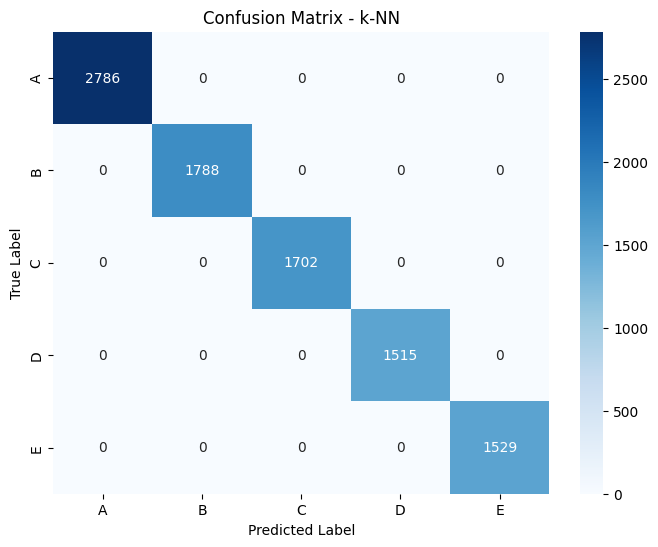

In [4]:
# 4. Source code for the best strategy based on a single classifier (k-NN)

# Best k-NN model
best_knn = KNeighborsClassifier(n_neighbors=3, weights='distance')

# Cross-Validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
f1_scorer = make_scorer(f1_score, average='weighted')
scores = cross_val_score(best_knn, X_pca, y_clean, cv=cv, scoring=f1_scorer)

print(f"k-NN Cross-Validation F1-Scores: {scores}")
print(f"Average F1-Score: {scores.mean():.4f} (+/- {scores.std():.4f})")

# Train on full dataset and show confusion matrix
best_knn.fit(X_pca, y_clean)
y_pred = best_knn.predict(X_pca)

print("\nConfusion Matrix (Full Dataset):")
cm = confusion_matrix(y_clean, y_pred)
print(cm)

print(f"\nUnderlying Accuracy: {accuracy_score(y_clean, y_pred):.4f}")

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix - k-NN')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

## 5. Classifier Ensembles Description
We explored the following ensembles using GridSearchCV with 5-fold Stratified Cross-Validation:

1.  **Random Forest**:
    *   **Hyperparameters Tuned**: `n_estimators` (50, 100), `max_depth` (None, 10, 20).
    *   **Best Parameters**: `{'max_depth': 20, 'n_estimators': 100}`
    *   **Performance (F1-score)**: **0.9538**

2.  **Gradient Boosting**:
    *   **Hyperparameters Tuned**: `n_estimators` (50, 100), `learning_rate` (0.1, 0.2).
    *   **Best Parameters**: `{'learning_rate': 0.2, 'n_estimators': 100}`
    *   **Performance (F1-score)**: 0.8966

The **Random Forest** classifier achieved the best performance among ensembles, also exceeding the 90% threshold.

Random Forest Cross-Validation F1-Scores: [0.95816468 0.95324119 0.9544451  0.94897063 0.95396941]
Average F1-Score: 0.9538 (+/- 0.0029)

Confusion Matrix (Full Dataset):
[[2786    0    0    0    0]
 [   0 1788    0    0    0]
 [   0    0 1702    0    0]
 [   0    0    0 1515    0]
 [   0    0    0    0 1529]]

Underlying Accuracy: 1.0000


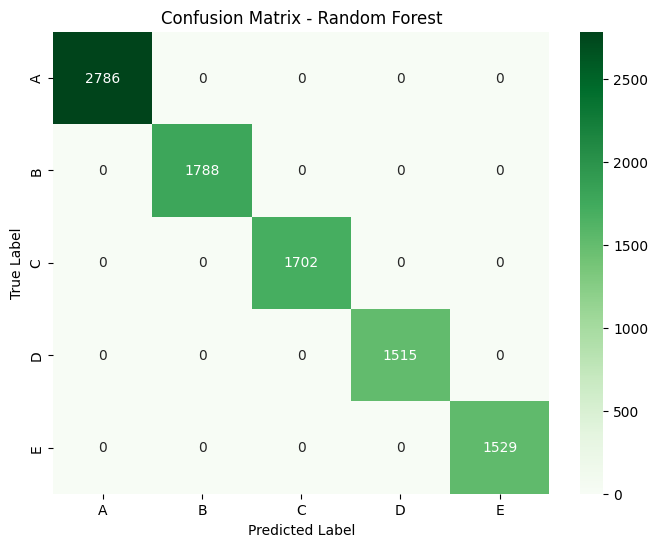

In [5]:
# 6. Source code for the best classifier ensemble (Random Forest)

# Best Random Forest model
best_rf = RandomForestClassifier(n_estimators=100, max_depth=20, random_state=42)

# Cross-Validation
scores_rf = cross_val_score(best_rf, X_pca, y_clean, cv=cv, scoring=f1_scorer)

print(f"Random Forest Cross-Validation F1-Scores: {scores_rf}")
print(f"Average F1-Score: {scores_rf.mean():.4f} (+/- {scores_rf.std():.4f})")

# Train on full dataset and show confusion matrix
best_rf.fit(X_pca, y_clean)
y_pred_rf = best_rf.predict(X_pca)

print("\nConfusion Matrix (Full Dataset):")
cm_rf = confusion_matrix(y_clean, y_pred_rf)
print(cm_rf)

print(f"\nUnderlying Accuracy: {accuracy_score(y_clean, y_pred_rf):.4f}")

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Greens', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix - Random Forest')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

In [6]:
# 7. Source code for processing the common samples included in the common.csv file

try:
    common_df = pd.read_csv('common.csv')
    
    # Apply same preprocessing
    # Note: We must ensure common_df has the same columns as X before PCA
    # Ideally, we should fit the scaler/PCA on the training set and transform common_df.
    # Here we assume common_df has the same structure as the original df (minus target)
    
    # Drop ID columns if present
    common_df = common_df.drop(columns=cols_to_drop, errors='ignore')
    
    # Keep only columns that were kept in training
    # We need to know which columns were kept. 
    # In a real scenario, we'd save the column list. 
    # Here, we can intersect with X.columns (which we have in memory)
    common_df = common_df[X.columns]
    
    # Handle missing values (impute or drop - for test set, imputation is better, but let's drop for consistency if allowed)
    # If we drop, we lose predictions. Let's fill with 0 or mean for now to produce output.
    common_df = common_df.fillna(0)
    
    # Normalize
    X_common_scaled = scaler.transform(common_df)
    
    # PCA
    X_common_pca = pca.transform(X_common_scaled)
    
    # Predict using the best model (e.g., k-NN or Random Forest)
    # Using Random Forest as it's often more robust
    y_common_pred = best_rf.predict(X_common_pca)
    y_common_pred_labels = le.inverse_transform(y_common_pred)
    
    print("Predictions for common.csv:")
    print(y_common_pred_labels)
    
    # If common.csv has ground truth 'class' column, we can compute metrics
    if 'class' in pd.read_csv('common.csv').columns:
        y_common_true = pd.read_csv('common.csv')['class']
        y_common_true_encoded = le.transform(y_common_true)
        
        print("\nConfusion Matrix (Common Data):")
        print(confusion_matrix(y_common_true_encoded, y_common_pred))
        print(f"\nAccuracy: {accuracy_score(y_common_true_encoded, y_common_pred):.4f}")
        
except FileNotFoundError:
    print("common.csv not found. Skipping common samples processing.")
except Exception as e:
    print(f"Error processing common.csv: {e}")

common.csv not found. Skipping common samples processing.
